

# TEAM PROJECT - Meta_World

> Install packages


In [ ]:
!pip install metaworld gymnasium[mujoco]

> Import packages

In [ ]:
import gymnasium as gym
import metaworld
from gymnasium import ActionWrapper

import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio

from typing import Dict, List, Union, Tuple, Optional
from copy import deepcopy

In [ ]:
def set_seed(seed: int, env=None):
    import random, numpy as np, torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if env is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)          # Discrete에도 정상 적용
        env.observation_space.seed(seed)

> Environment

In [ ]:
import os
os.environ["MUJOCO_GL"] = "egl"

Observation space: Box([-0.525   0.348  -0.0525 -1.        -inf    -inf    -inf    -inf    -inf
    -inf    -inf    -inf    -inf    -inf    -inf    -inf    -inf    -inf
 -0.525   0.348  -0.0525 -1.        -inf    -inf    -inf    -inf    -inf
    -inf    -inf    -inf    -inf    -inf    -inf    -inf    -inf    -inf
  0.      0.      0.    ], [0.525 1.025 0.7   1.      inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf 0.525 1.025 0.7   1.      inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
 0.    0.    0.   ], (39,), float64)
Action space: Box(-1.0, 1.0, (4,), float32)


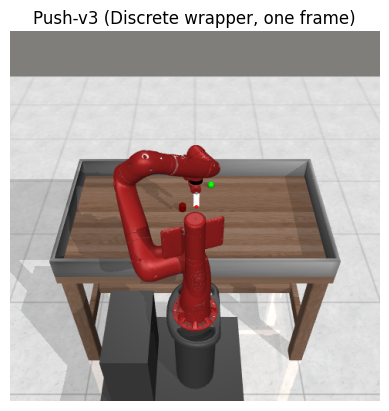

In [ ]:
# 예: MT1 벤치마크의 reach task 사용
env = gym.make("Meta-World/MT1", env_name="push-v3", render_mode="rgb_array", seed=42)

obs, info = env.reset(seed=42)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

frame = env.render()   # 한 장면 (numpy array)

plt.imshow(frame)
plt.axis("off")
plt.title("Push-v3 (Discrete wrapper, one frame)")
plt.show()

env.close()

> Convert from continuous actions to discrete actions

In [ ]:
class DiscretizeActionWrapper(gym.ActionWrapper):
    def __init__(self, env, bins_per_dim=3):
        super().__init__(env)
        self.bins_per_dim = bins_per_dim
        self.low = env.action_space.low
        self.high = env.action_space.high
        self.action_dim = env.action_space.shape[0]

        # 각 차원을 bins로 나누고, 전체 discrete action space 크기 정의
        self.discrete_actions = self._create_discrete_actions()
        self.action_space = gym.spaces.Discrete(len(self.discrete_actions))

    def _create_discrete_actions(self):
        # 각 차원을 linspace로 나누고 meshgrid → 모든 조합
        grids = [
            np.linspace(self.low[i], self.high[i], self.bins_per_dim)
            for i in range(self.action_dim)
        ]
        mesh = np.meshgrid(*grids)
        combos = np.stack(mesh, axis=-1).reshape(-1, self.action_dim)
        return combos

    def action(self, action_idx):
        return self.discrete_actions[action_idx]

In [ ]:
# Meta-World pick-place 환경
env = gym.make("Meta-World/MT1", env_name="push-v3", seed=42)

# Wrapper로 discrete 변환 (예: 각 차원 3개 bin → 3^4 = 81 actions)
env = DiscretizeActionWrapper(env, bins_per_dim=3)

print("New Action Space:", env.action_space)   # e.g. Discrete(81)

obs, info = env.reset()
print("Observation shape:", obs.shape)  # (39,)

New Action Space: Discrete(81)
Observation shape: (39,)


## DQN baseline

In [ ]:
# Define the Q-network
class QNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dims:[List[int]],
        activation: nn.Module = nn.ReLU,
    ) -> None:
        super(QNetwork, self).__init__()
        hidden_dims = [input_dim] + list(hidden_dims)
        model = []

        for in_dim, out_dim in zip(hidden_dims[:-1], hidden_dims[1:]):
            model += [nn.Linear(in_dim, out_dim), activation()]

        model += [nn.Linear(hidden_dims[-1], output_dim)]
        self.model = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [ ]:
from collections import deque

class DQNAgent:
    def __init__(
        self,
        q_network: nn.Module,
        optimizer: optim.Optimizer,
        input_dim: int,
        output_dim: int,
        epsilon_start: float,
        epsilon_final: float,
        epsilon_decay: float,
        target_update: int,
        batch_size: int,
        memory_capacity: int,
        gamma: float,
        tau: float
    ) -> None:
        self.q_network, self.target_network = q_network, deepcopy(q_network)
        self.target_network.eval()
        self.optimizer = optimizer

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.epsilon = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay

        self.target_update = target_update
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

        self.memory = deque(maxlen=memory_capacity)
        self.steps = 0

        self.criterion = nn.MSELoss()

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.output_dim - 1)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state)
            return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.view(-1, 1)).squeeze()

        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1).values

        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.criterion(q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 10.0)
        self.optimizer.step()

        self.epsilon = max(self.epsilon_final, self.epsilon * self.epsilon_decay)

        self.steps += 1
        if self.steps % self.target_update == 0:
            for t, q in zip(self.target_network.parameters(), self.q_network.parameters()):
                t.data.copy_(t.data * (1.0 - self.tau) + q.data * self.tau)

In [ ]:
# Q-network 생성
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
q_net = QNetwork(input_dim, output_dim, hidden_dims=[128, 128])

optimizer = optim.Adam(q_net.parameters(), lr=1e-3)

# DQN Agent 생성
agent = DQNAgent(
    q_network=q_net,
    optimizer=optimizer,
    input_dim=input_dim,
    output_dim=output_dim,
    epsilon_start=1.0,
    epsilon_final=0.05,
    epsilon_decay=0.995,
    target_update=100,
    batch_size=64,
    memory_capacity=50_000,
    gamma=0.99,
    tau=1.0
)

In [ ]:
num_episodes = 100
max_steps = env.spec.max_episode_steps

env = gym.make("Meta-World/MT1", env_name="reach-v3", seed=42)
env = DiscretizeActionWrapper(env, bins_per_dim=3)
set_seed(42, env)

for ep in range(num_episodes):
    state, _ = env.reset()
    state = np.array(state, dtype=np.float32).flatten()
    total_reward, success_count = 0, 0

    for t in range(max_steps):
        action = agent.select_action(state)
        next_state, reward, done, truncated, info = env.step(action)
        next_state = np.array(next_state, dtype=np.float32).flatten()

        agent.store_experience(state, action, reward, next_state, float(done))
        agent.train()

        state = next_state
        total_reward += reward
        success_count += info.get("success", 0)

        if done or truncated:
            break

    print(f"Ep {ep} | Reward: {total_reward:.2f} | Success: {success_count>0} | Eps: {agent.epsilon:.3f}")